<a href="https://colab.research.google.com/github/wendystep2221/LDA-resumenes-NFS/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="color:#00CED1;" align="center"> Prueba Científico de Datos EPS Sanitas : Resúmenes de los premios de investigación de la NSF</h1> 

Wendy Stephanie García Peñuela\
wendysgarciap@gmail.com

<h2 style="color:#00CED1;" align="left"> Problema </h2> 

Desarrollar un modelo no supervisado que clasifique los resúmenes dentro de un tema específico, es decir, agrupar los resúmenes basado en su similitud semántica.

<h2 style="color:#00CED1;" align="left"> Metodología propuesta </h2> 

Se propone para la solución de este problema un modelo de **Asignación Latente de Dirichlet** o **LDA** por sus siglas en inglés. Este modelo asocia tópicos a cada documento (en nuestro caso résumenes de artículos de investigación
que fueron extraídos por la Fundación Nacional de Ciencia) de acuerdo a las palabras contenidas en cada uno. Cada tópico tiene una medida de aporte entre 0 y 1 al documento (probabilidad), siendo posible extraer el tópico que más aporta o se ajusta para así crear grupos especificos.

**NOTA: El resultado del estudio arrojó 14 grupos, adjunto se encuentra un archivo de tipo pickle(.pkl) que contiene la asignación de acuerdo al ID de cada articulo: "df_topics.pkl" , Adicional a ello se puede visualizar cada tópico en el documento "LDA-14-topics.html"**

<h2 style="color:#00CED1;" align="center"> Lectura de datos </h2>

In [ ]:
!pip install pyLDAvis
!pip install dask
!pip install "dask[dataframe]"

In [ ]:
# Librerías en uso
import os
import pandas as pd
import numpy as np
import zipfile
import pickle

import xml.etree.ElementTree as ET
import lxml.etree as etree
from bs4 import BeautifulSoup


import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re, unicodedata

from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

import spacy
import spacy.cli
spacy.cli.download("en_core_web_sm")

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from pprint import pprint
import matplotlib.pyplot as plt

from dask import delayed
from dask import compute
import dask.dataframe as ddf



nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
utils = importr('utils')
#stanza.download('en')
#nlp = stanza.Pipeline('en')
#conda install -c conda-forge fastparquet
#conda install -c conda-forge dask-ml

In [ ]:
import pandas as pd 
import numpy as np
import os 

stop_words = list(stopwords.words("english"))
os.chdir('C:/Users/David.solano/OneDrive - Ipsos/David/Datos')

### Lectura 

In [ ]:
data_lemmatized = pd.read_pickle('Text_lemmatized.pkl')

# Preparación del conjunto de datos

In [ ]:
## Preliminares
path='/NLP/Prueba sanitas/Datos/' # Cambiar de acuerdo a la ubicación del proyecto
#os.listdir(path)

In [ ]:
#Leer zip
abstracts = zipfile.ZipFile(path+'NLP prueba 1.zip', 'r')


In [ ]:
# visualizacion xml
x = abstracts.open(abstracts.namelist()[0])
print(BeautifulSoup(x, "xml").prettify())

In [ ]:
def xml2df(xml_data):
    tree = ET.parse(xml_data)
    root = tree.getroot()# element tree
    all_records = []
    for i, child in enumerate(root):
      record = {}
      for subchild in child:
        #Busca todos los nodos de primer nivel
        record[subchild.tag] = subchild.text
        try:
          for subsubchild in subchild:
            #Busca todos los nodos de segundo nivel
            #Si el nodo de segundo nivel es ProgramReference_Text, entonces concatena separados por . todos los  ProgramReference que encuentre en el archivo
            if subchild.tag+"_"+subsubchild.tag=='ProgramReference_Text':
              try:
                record[subchild.tag+"_"+subsubchild.tag] =record[subchild.tag+"_"+subsubchild.tag]+'.'+ subsubchild.text
              except:
                record[subchild.tag+"_"+subsubchild.tag]= subsubchild.text
            else:
              record[subchild.tag+"_"+subsubchild.tag] = subsubchild.text
        except:
          record[subchild.tag] = subchild.text
      all_records.append(record)
    return pd.DataFrame(all_records)

In [ ]:
#Crear dataframe con los resumenes
data = pd.DataFrame()
for abstract in abstracts.namelist():
  data=data.append(xml2df(abstracts.open(abstract)),ignore_index=True)

Se extrajo todos los xml en un dataframe, se usará un LDA para el analisis y clusterización. por esto se concatenará : awardTitle,abstract, programreferences

In [ ]:
data['Title_Resume_ProgramRef'] = data[['AwardTitle', 'AbstractNarration', 'ProgramReference_Text']].astype(str).agg('-'.join, axis=1)

# Pre-procesamiento del texto


In [ ]:
#Dataframe con ID y texto
Text=data[['AwardID','Title_Resume_ProgramRef']]
Text=Text.set_index('AwardID')

In [ ]:
stop_words=stopwords.words()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def tokenizador(text):
    return(' '.join(word_tokenize(text)))


def sent_to_words(sentence):
    return(gensim.utils.simple_preprocess(str(sentence), deacc=True))

#Quitar stop words
def remove_stopwords(doc):
    return ' '.join([word.strip() for word in simple_preprocess(str(doc)) if word.strip() not in stop_words])

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#Identificar partes de la oración y conservar ciertas palabras
def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','INTJ']): 
    doc = nlp(text)
    return  [token.lemma_ for token in doc if token.pos_ in allowed_postags]

#Devuelve los datos limpios
def clean_text(df, variable = 'Title_Resume_ProgramRef'):
    
    data_lemmatized = df[variable][~df[variable].isna()].map(tokenizador).map(sent_to_words).map(remove_stopwords).map(lemmatization)
    
    filtro = data_lemmatized.map(len) > 0 
    data_lemmatized = data_lemmatized[filtro]
    
    return data_lemmatized

In [ ]:
Text.tail(5)

,AwardID,Title_Resume_ProgramRef
13200,2055767,National Center for Next Generation Manufactur...
13201,2055771,NSF-BSF: Dynamics and Operator Algebras beyond...
13202,2055772,Collaborative Research: SaTC: CORE: Medium: Na...
13203,2055773,Collaborative Research: SaTC: CORE: Medium: Na...
13204,2055781,Increasing the Cloud System Administration Ser...


In [ ]:
#Lematizacion
%%time
data_lemmatized = clean_text(Text,variable = 'Title_Resume_ProgramRef')

In [ ]:
len(data_lemmatized)

13198

In [ ]:
# Guardar Texto Lema
data_lemmatized.to_pickle(path= path+'Text_lemmatized.pkl')


In [ ]:
# Abrir Texto Lema
data_lemmatized=pd.read_pickle(path+'Text_lemmatized.pkl')

In [ ]:
data_lemmatized[:10]

AwardID
2000005    [gbx, neural, cell, neuronal, craniofacial, de...
2000009    [community, engage, educational, identify, sol...
2000012    [provide, year, funding, help, defray, expense...
2000021    [scale, assess, epistemic, exclusion, minoriti...
2000028    [award, synthesis, imidazole, compound, invest...
2000029    [calculation, nucleon, bind, state, understand...
2000033    [area, hold, free, participant, promote, educa...
2000034    [geometric, variational, problem, surface, ten...
2000036    [research, award, unravel, elemental, abundanc...
2000037    [modern, aspect, multivariable, operator, theo...
Name: Title_Resume_ProgramRef, dtype: object

<h3 style = 'color:black;' > Algunas visualizaciones </h3>

In [ ]:
from itertools import chain
from prettytable import PrettyTable
from collections import Counter

words = list(chain.from_iterable(data_lemmatized))
pt = PrettyTable(field_names=['Palabra', 'Conteo']) 

c = Counter(words)
[ pt.add_row(kv) for kv in c.most_common()[:50] ]
pt.align['Palabra'], pt.align['Conteo'] = 'l', 'r' 
pt._max_width = {'Palabra':60, 'Conteo':10}
print(pt)

+---------------+--------+
| Palabra       | Conteo |
+---------------+--------+
| project       |  42522 |
| use           |  38273 |
| research      |  31460 |
| support       |  24597 |
| student       |  24572 |
| impact        |  22528 |
| broad         |  17660 |
| develop       |  16902 |
| system        |  16393 |
| model         |  16209 |
| datum         |  14762 |
| new           |  14015 |
| evaluation    |  13972 |
| provide       |  13925 |
| foundation    |  13794 |
| review        |  13358 |
| intellectual  |  13303 |
| reflect       |  13288 |
| mission       |  13249 |
| merit         |  13174 |
| include       |  13030 |
| deem          |  12902 |
| statutory     |  12887 |
| worthy        |  12887 |
| high          |  12732 |
| criterion     |  12688 |
| study         |  12616 |
| science       |  11889 |
| program       |  11310 |
| base          |  10653 |
| material      |  10414 |
| design        |   9903 |
| community     |   9667 |
| stem          |   9620 |
|

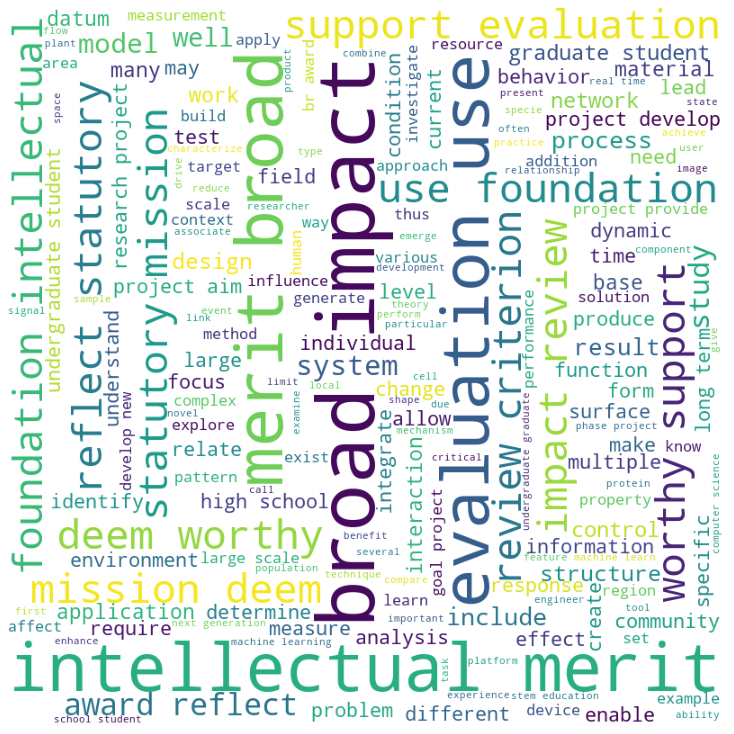

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

str_words = ' '.join(words) 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(str_words)
                    
plt.figure(figsize = (10,10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

<h2 style = 'color:#00CED1;' align ='center' > Diccionario - Corpus - TFIDF </h2>

In [ ]:
id2word = corpora.Dictionary(data_lemmatized)
print(len(id2word))
id2word.filter_extremes(no_below=10, no_above=0.7, keep_n=10000) # Esta aplica cuando hay muchas palabras 
print(len(id2word))

texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

tfidf = gensim.models.TfidfModel(corpus, smartirs='npc')
corpus_tfidf = tfidf[corpus]

29481
8201


<h2 style='color:#00CED1;' align = 'center' > LDA </h2> 

In [ ]:
def models_computation(corpus, limit, start=2, step=3):
    
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = delayed(gensim.models.LdaMulticore)(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=10, workers=8)
        model_list.append(model)
        
    return model_list 

def coherence_perplexity_values_computation(model_list, dictionary, texts):
    
    coherence_values = []
    perplexity_values = []
    
    for model in model_list:
        coherencemodel = delayed(CoherenceModel)(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity = delayed(model.log_perplexity)(corpus)
        perplexity_values.append(perplexity)
    
    return coherence_values, perplexity_values

In [ ]:
%%time
limit=20; step=3;start=8
result = models_computation(corpus=corpus_tfidf, limit=limit, step=step, start = start)
model_list = compute(*result)
result = coherence_perplexity_values_computation(model_list=model_list, dictionary=id2word, texts=data_lemmatized)
coherence_values, perplexity_values = compute(*result)

Wall time: 29min 8s


In [ ]:
# Guardar resultados de los modelos LDA

with open('model_list_LDA.pkl', 'wb') as f:
    pickle.dump(model_list, f)

with open('coherence_values_LDA.pkl', 'wb') as f:
    pickle.dump(coherence_values, f)

with open('perplexity_values_LDA.pkl', 'wb') as f:
    pickle.dump(perplexity_values, f)

In [ ]:
#Abrir resultados de los modelos LDA

with open(path+'model_list_LDA15.pkl', 'rb') as f:
     model_list = pickle.load(f)
with open(path+'coherence_values_LDA15.pkl', 'rb') as f:
     coherence_values = pickle.load(f)
with open(path+'perplexity_values_LDA15.pkl', 'rb') as f:
     perplexity_values = pickle.load(f)

### Perplexity y Coherencia - Evaluación del número de Tópicos

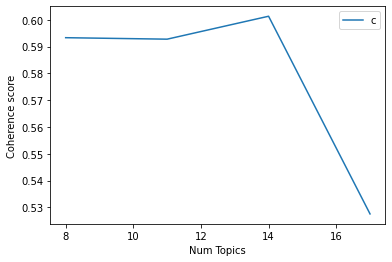

In [ ]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 8  is having Coherence Value of 0.5933
Num Topics = 11  is having Coherence Value of 0.5928
Num Topics = 14  is having Coherence Value of 0.6013
Num Topics = 17  is having Coherence Value of 0.5276


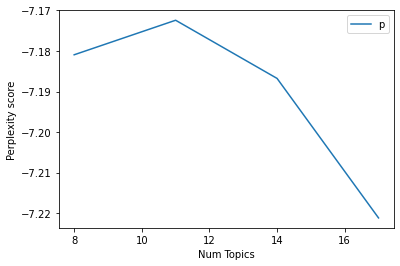

In [ ]:
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, perplexity_values):
    print("Num Topics =", m, " is having Perplexity Value of", round(cv, 4))

Num Topics = 8  is having Perplexity Value of -7.1809
Num Topics = 11  is having Perplexity Value of -7.1724
Num Topics = 14  is having Perplexity Value of -7.1868
Num Topics = 17  is having Perplexity Value of -7.2212


In [ ]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.013*"teacher" + 0.008*"faculty" + 0.007*"practice" + 0.006*"college" + '
  '0.006*"course" + 0.005*"professional" + 0.005*"skill" + 0.005*"institution" '
  '+ 0.005*"teach" + 0.004*"mathematic"'),
 (1,
  '0.005*"software" + 0.004*"device" + 0.004*"user" + 0.004*"hardware" + '
  '0.004*"machine" + 0.004*"power" + 0.004*"wireless" + 0.004*"phase" + '
  '0.004*"algorithm" + 0.004*"compute"'),
 (2,
  '0.010*"plant" + 0.009*"cell" + 0.009*"specie" + 0.007*"gene" + '
  '0.007*"protein" + 0.005*"genetic" + 0.005*"virus" + 0.005*"host" + '
  '0.005*"microbial" + 0.004*"animal"'),
 (3,
  '0.022*"battery" + 0.009*"ion" + 0.008*"energy" + 0.008*"electrode" + '
  '0.007*"water" + 0.007*"storage" + 0.006*"electrochemical" + 0.006*"metal" + '
  '0.005*"hydrogen" + 0.005*"emission"'),
 (4,
  '0.062*"fellowship" + 0.022*"earthquake" + 0.020*"fault" + 0.017*"pursue" + '
  '0.013*"federal" + 0.013*"outstanding" + 0.012*"achievement" + '
  '0.012*"master" + 0.011*"institution" + 0.011*"fellow"'

### Tópico dominante por respuesta

In [ ]:
optimal_model[corpus_tfidf]

In [ ]:
import dask.bag as bd 

row_bd = bd.from_sequence(enumerate(optimal_model[corpus_tfidf]), npartitions = 1000)

In [ ]:
def topics(df):
    
    sent_topics_df = []
    
    for i, row in df:
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = optimal_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.append(dict(Dominant_Topic = int(topic_num), 
                                                            Perc_Contribution = round(prop_topic,4),
                                                            Topic_Keywords = topic_keywords))
            else:
                break
    
    return sent_topics_df


In [ ]:
%%time
sent_topics_df = row_bd.map_partitions(topics)

CPU times: user 54.2 ms, sys: 1.86 ms, total: 56.1 ms
Wall time: 55 ms


In [ ]:
%%time
sent_topics_df = sent_topics_df.to_dataframe()
sent_topics_df.head()

CPU times: user 122 ms, sys: 155 ms, total: 277 ms
Wall time: 349 ms


In [ ]:
topics_df = sent_topics_df.compute()
topics_df['ID'] = list(data_lemmatized.index.values)
topics_df['Dominant_Topic'] = topics_df['Dominant_Topic'] + 1 

#Guarda los tópicos más probables para cada articulo
topics_df.to_pickle(path= path+'df_topics.pkl')

In [ ]:
df_Topics = sent_topics_df.groupby('Dominant_Topic')['Perc_Contribution'].count().compute()
x = df_Topics.index + 1 
x = [str(int(inte)) for inte in x]
y = df_Topics.values
y = y/sum(y)

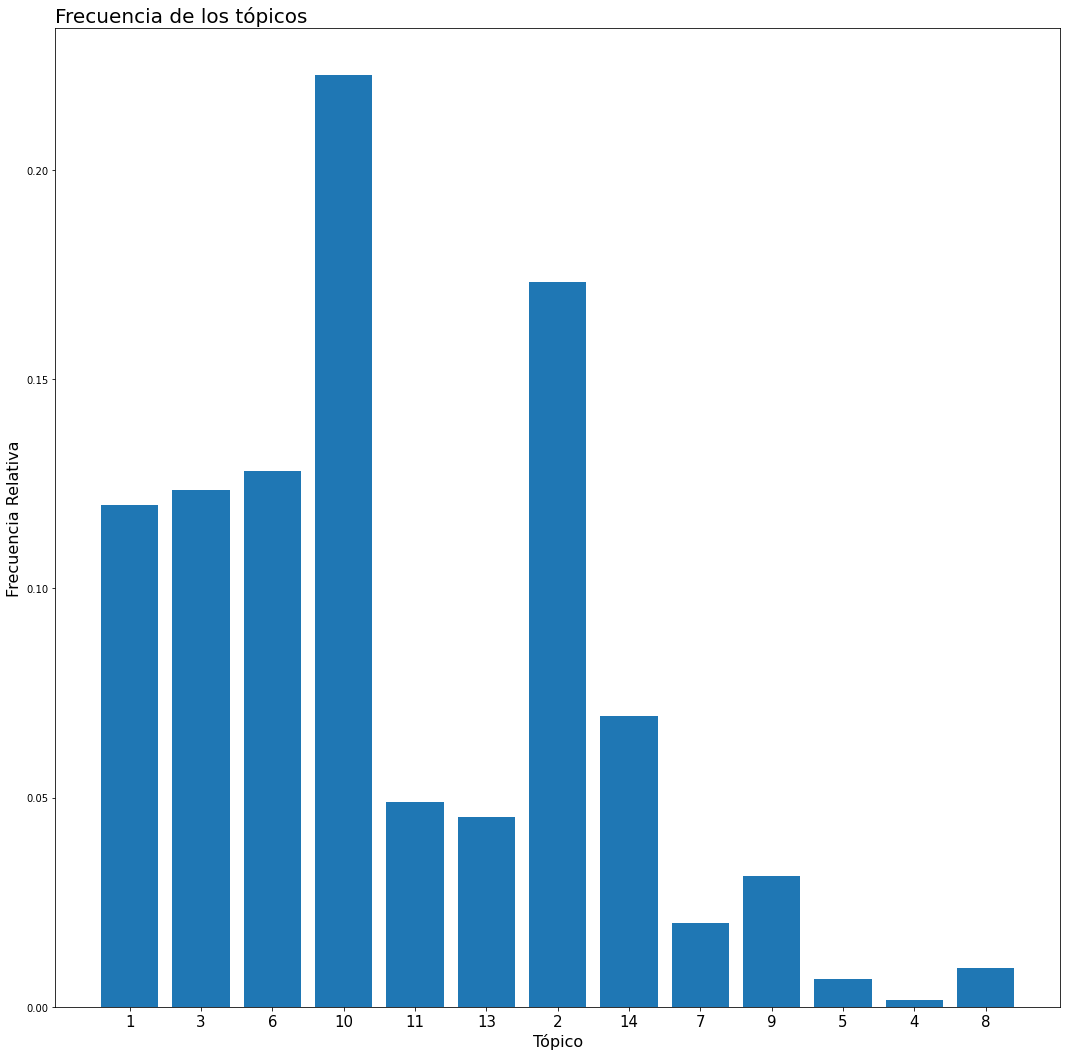

In [ ]:
import matplotlib

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=10)

fig, ax = plt.subplots()
fig.set_size_inches(18, 18)
ax.bar(x,y)

ax.set_title('Frecuencia de los tópicos', fontsize=20, loc = 'left')
ax.set_xlabel('Tópico', fontsize=16)
ax.set_ylabel('Frecuencia Relativa', fontsize=16)

plt.show()

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus_tfidf, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.043083 -0.079503       1        1  20.611257
1     -0.036817 -0.083412       2        1  16.095217
5     -0.061642  0.057171       3        1  12.241283
2      0.066300  0.051842       4        1  12.235509
0     -0.134117  0.072665       5        1  11.238893
13     0.081168  0.038232       6        1   6.945213
12     0.117337  0.072487       7        1   4.873295
10    -0.089261 -0.002047       8        1   4.844591
8      0.050388 -0.082142       9        1   3.190364
6     -0.023200 -0.069403      10        1   2.749100
7     -0.074863 -0.007568      11        1   1.681987
4      0.008755  0.024412      12        1   1.213215
3      0.050121  0.002617      13        1   1.149137
11     0.002747  0.004649      14        1   0.930940, topic_info=             Term        Freq       Total Category  logprob  loglift
2341   fellowship   99.000000   99.000000  Default  30.0000  30.0000
130         water  173.000000  173.000000  Default  29.0000  29.0000
76     conference  124.000000  124.000000  Default  28.0000  28.0000
39    institution  117.000000  117.000000  Default  27.0000  27.0000
1019      battery   51.000000   51.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
116        social    1.031546  148.850981  Topic14  -6.6725  -0.2952
695       compute    0.954600  108.010163  Topic14  -6.7500  -0.0520
1178      machine    0.980866  131.866426  Topic14  -6.7228  -0.2244
165          site    0.956211  127.209326  Topic14  -6.7483  -0.2139
248       protein    0.925179  140.194692  Topic14  -6.7813  -0.3441

[719 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2399      2  0.742186  abstraction
2399      5  0.067471  abstraction
2399     10  0.067471  abstraction
132       1  0.063081     academic
132       2  0.063081     academic
...     ...       ...          ...
1844      9  0.015790         zone
1844     10  0.015790         zone
1844     12  0.031581         zone
1844     13  0.015790         zone
1844     14  0.015790         zone

[4726 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 6, 3, 1, 14, 13, 11, 9, 7, 8, 5, 4, 12])

In [ ]:
#os.chdir('../SALIDAS')
pyLDAvis.save_html(vis, 'LDA-14-topics.html')